## Obligasi Korporasi

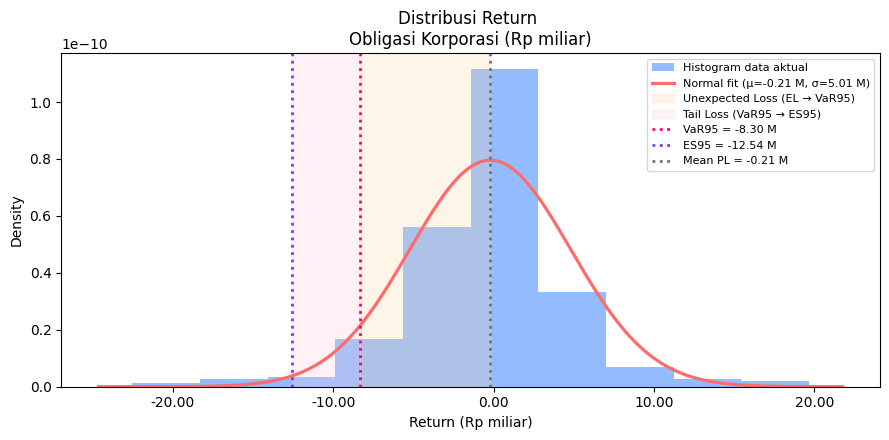

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_CorpBond.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_CorpBond"          # ganti dengan nama kolom PL
ASSET_NAME = "Obligasi Korporasi"     # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

q05 = series.quantile(1 - alpha)    # VaR95 di ruang PL

losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp MILIAR
# =========================

def miliar_number(x):
    """Konversi rupiah ke 'Rp miliar' dalam bentuk string, 1 desimal."""
    return f"{x / 1e9:,.2f}" 

axis_fmt = FuncFormatter(lambda val, pos: miliar_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"   
fit_color    = "#ff6b6b"   
ul_color     = "#ffd6a5"   
tail_color   = "#ffc8dd"   
var_color    = "#ff006e"   
es_color     = "#8338ec"   
mean_color   = "#6c757d"   

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
x = np.linspace(x_min - 0.05 * x_range,
                x_max + 0.05 * x_range,
                400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={miliar_number(mu)} M, σ={miliar_number(sigma)} M)")

# Zona UL (EL → VaR95)
ul_left  = min(mu, q05)
ul_right = max(mu, q05)
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (EL → VaR95)")

# Zona Tail Loss (VaR95 → ES95)
tail_left  = min(q05, ES95_pl)
tail_right = max(q05, ES95_pl)
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (VaR95 → ES95)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = {miliar_number(q05)} M")

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {miliar_number(ES95_pl)} M")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean PL = {miliar_number(mu)} M")

# Sumbu x dalam Rp juta
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp miliar)")
ax.set_xlabel("Return (Rp miliar)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## EBA

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_EBA.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_EBA"          # ganti dengan nama kolom PL
ASSET_NAME = "EBA"     # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

q05 = series.quantile(1 - alpha)    # VaR95 di ruang PL

losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp MILIAR
# =========================

def miliar_number(x):
    """Konversi rupiah ke 'Rp miliar' dalam bentuk string, 1 desimal."""
    return f"{x / 1e9:,.2f}" 

axis_fmt = FuncFormatter(lambda val, pos: miliar_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"   
fit_color    = "#ff6b6b"   
ul_color     = "#ffd6a5"   
tail_color   = "#ffc8dd"   
var_color    = "#ff006e"   
es_color     = "#8338ec"   
mean_color   = "#6c757d"   

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
x = np.linspace(x_min - 0.05 * x_range,
                x_max + 0.05 * x_range,
                400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={miliar_number(mu)} M, σ={miliar_number(sigma)} M)")

# Zona UL (EL → VaR95)
ul_left  = min(mu, q05)
ul_right = max(mu, q05)
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (EL → VaR95)")

# Zona Tail Loss (VaR95 → ES95)
tail_left  = min(q05, ES95_pl)
tail_right = max(q05, ES95_pl)
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (VaR95 → ES95)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = {miliar_number(q05)} M")

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {miliar_number(ES95_pl)} M")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean PL = {miliar_number(mu)} M")

# Sumbu x dalam Rp juta
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp miliar)")
ax.set_xlabel("Return (Rp miliar)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'PL_EBA.xlsx'

## MTN

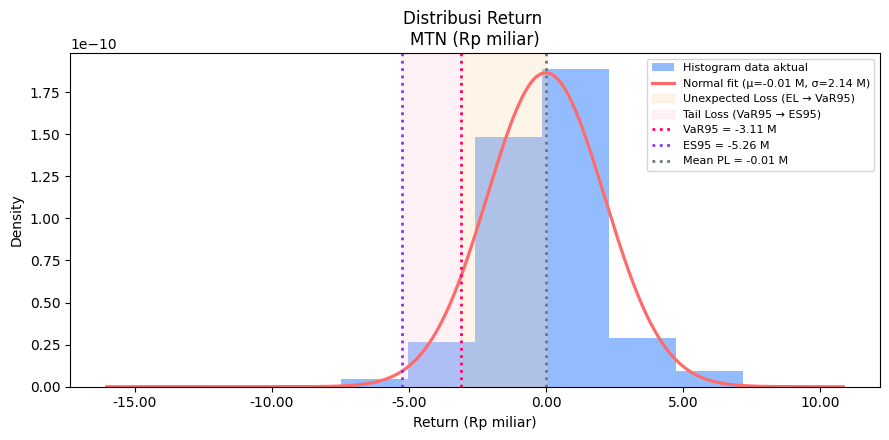

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_MTN.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_MTN"          # ganti dengan nama kolom PL
ASSET_NAME = "MTN"     # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

q05 = series.quantile(1 - alpha)    # VaR95 di ruang PL

losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp MILIAR
# =========================

def miliar_number(x):
    """Konversi rupiah ke 'Rp miliar' dalam bentuk string, 1 desimal."""
    return f"{x / 1e9:,.2f}" 

axis_fmt = FuncFormatter(lambda val, pos: miliar_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"   
fit_color    = "#ff6b6b"   
ul_color     = "#ffd6a5"   
tail_color   = "#ffc8dd"   
var_color    = "#ff006e"   
es_color     = "#8338ec"   
mean_color   = "#6c757d"   

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
x = np.linspace(x_min - 0.05 * x_range,
                x_max + 0.05 * x_range,
                400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={miliar_number(mu)} M, σ={miliar_number(sigma)} M)")

# Zona UL (EL → VaR95)
ul_left  = min(mu, q05)
ul_right = max(mu, q05)
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (EL → VaR95)")

# Zona Tail Loss (VaR95 → ES95)
tail_left  = min(q05, ES95_pl)
tail_right = max(q05, ES95_pl)
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (VaR95 → ES95)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = {miliar_number(q05)} M")

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {miliar_number(ES95_pl)} M")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean PL = {miliar_number(mu)} M")

# Sumbu x dalam Rp juta
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp miliar)")
ax.set_xlabel("Return (Rp miliar)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## Saham

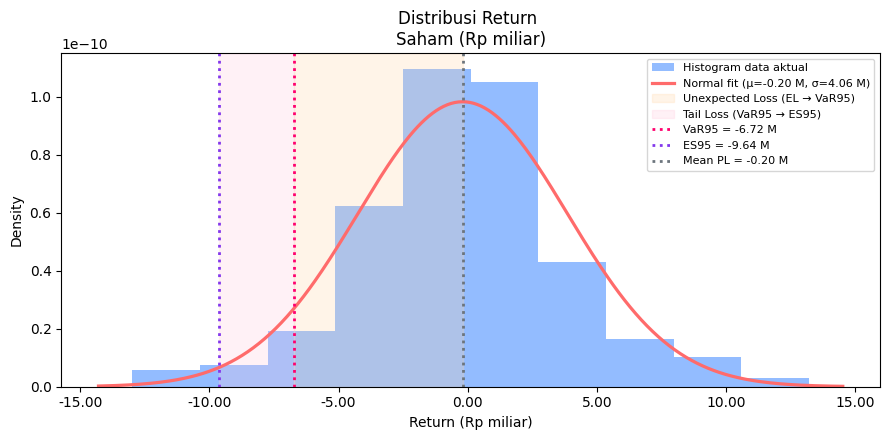

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_saham.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_saham"          # ganti dengan nama kolom PL
ASSET_NAME = "Saham"     # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

q05 = series.quantile(1 - alpha)    # VaR95 di ruang PL

losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp MILIAR
# =========================

def miliar_number(x):
    """Konversi rupiah ke 'Rp miliar' dalam bentuk string, 1 desimal."""
    return f"{x / 1e9:,.2f}" 

axis_fmt = FuncFormatter(lambda val, pos: miliar_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"   
fit_color    = "#ff6b6b"   
ul_color     = "#ffd6a5"   
tail_color   = "#ffc8dd"   
var_color    = "#ff006e"   
es_color     = "#8338ec"   
mean_color   = "#6c757d"   

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
x = np.linspace(x_min - 0.05 * x_range,
                x_max + 0.05 * x_range,
                400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={miliar_number(mu)} M, σ={miliar_number(sigma)} M)")

# Zona UL (EL → VaR95)
ul_left  = min(mu, q05)
ul_right = max(mu, q05)
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (EL → VaR95)")

# Zona Tail Loss (VaR95 → ES95)
tail_left  = min(q05, ES95_pl)
tail_right = max(q05, ES95_pl)
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (VaR95 → ES95)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = {miliar_number(q05)} M")

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {miliar_number(ES95_pl)} M")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean PL = {miliar_number(mu)} M")

# Sumbu x dalam Rp juta
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp miliar)")
ax.set_xlabel("Return (Rp miliar)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## Reksa Dana

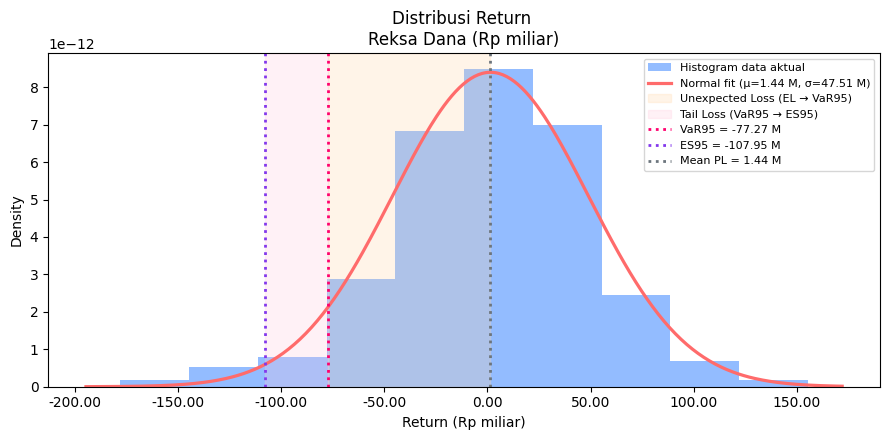

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_RD.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_RD"          # ganti dengan nama kolom PL
ASSET_NAME = "Reksa Dana"     # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

q05 = series.quantile(1 - alpha)    # VaR95 di ruang PL

losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp MILIAR
# =========================

def miliar_number(x):
    """Konversi rupiah ke 'Rp miliar' dalam bentuk string, 1 desimal."""
    return f"{x / 1e9:,.2f}" 

axis_fmt = FuncFormatter(lambda val, pos: miliar_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"   
fit_color    = "#ff6b6b"   
ul_color     = "#ffd6a5"   
tail_color   = "#ffc8dd"   
var_color    = "#ff006e"   
es_color     = "#8338ec"   
mean_color   = "#6c757d"   

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
x = np.linspace(x_min - 0.05 * x_range,
                x_max + 0.05 * x_range,
                400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={miliar_number(mu)} M, σ={miliar_number(sigma)} M)")

# Zona UL (EL → VaR95)
ul_left  = min(mu, q05)
ul_right = max(mu, q05)
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (EL → VaR95)")

# Zona Tail Loss (VaR95 → ES95)
tail_left  = min(q05, ES95_pl)
tail_right = max(q05, ES95_pl)
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (VaR95 → ES95)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = {miliar_number(q05)} M")

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {miliar_number(ES95_pl)} M")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean PL = {miliar_number(mu)} M")

# Sumbu x dalam Rp juta
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp miliar)")
ax.set_xlabel("Return (Rp miliar)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## Saham Full

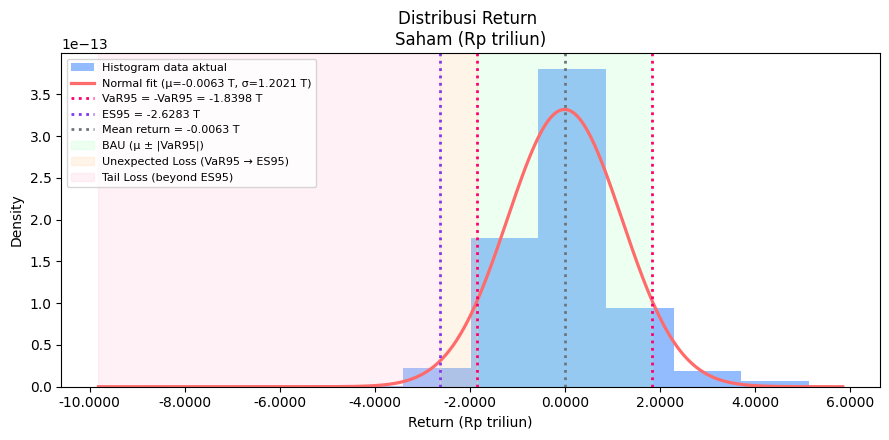

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_saham_full.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_saham"               # ganti dengan nama kolom PL
ASSET_NAME = "Saham"                  # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

# VaR95 di ruang PL (5% kiri; biasanya negatif)
q05 = series.quantile(1 - alpha)

# Expected Shortfall 95%
losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp TRILIUN
# =========================

def triliun_number(x: float) -> str:
    """Konversi rupiah ke 'Rp triliun' (dalam string, 4 desimal)."""
    return f"{x / 1e12:,.4f}"

axis_fmt = FuncFormatter(lambda val, pos: triliun_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"
fit_color    = "#ff6b6b"
bau_color    = "#a5ffbd"   # BAU zone
ul_color     = "#ffd6a5"   # UL zone
tail_color   = "#ffc8dd"   # Tail Loss zone
var_color    = "#ff006e"
es_color     = "#8338ec"
mean_color   = "#6c757d"

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
pad_left = x_min - 0.05 * x_range
pad_right = x_max + 0.05 * x_range

x = np.linspace(pad_left, pad_right, 400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={triliun_number(mu)} T, σ={triliun_number(sigma)} T)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = -VaR95 = {triliun_number(q05)} T")

# Garis -VaR95
ax.axvline(-q05,
           linestyle=":",
           linewidth=2,
           color=var_color,)

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {triliun_number(ES95_pl)} T")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean return = {triliun_number(mu)} T")

# === ZONA BAU: μ ± |VaR95| (business-as-usual) ===
var_width = abs(q05)
bau_left  = mu - var_width
bau_right = mu + var_width
ax.axvspan(bau_left, bau_right,
           alpha=0.20,
           color=bau_color,
           label="BAU (μ ± |VaR95|)")

# === ZONA UL: dari VaR95 ke ES95 ===
ul_left  = ES95_pl
ul_right = q05
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (VaR95 → ES95)")

# === ZONA TAIL LOSS: dari ES95 ke arah kerugian yang lebih dalam ===
# (diasumsikan tail kerugian di sisi kiri, ES95_pl < q05 < mu)
tail_left  = pad_left
tail_right = ES95_pl
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (beyond ES95)")

# Sumbu x dalam Rp triliun
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp triliun)")
ax.set_xlabel("Return (Rp triliun)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## Reksa Dana Full

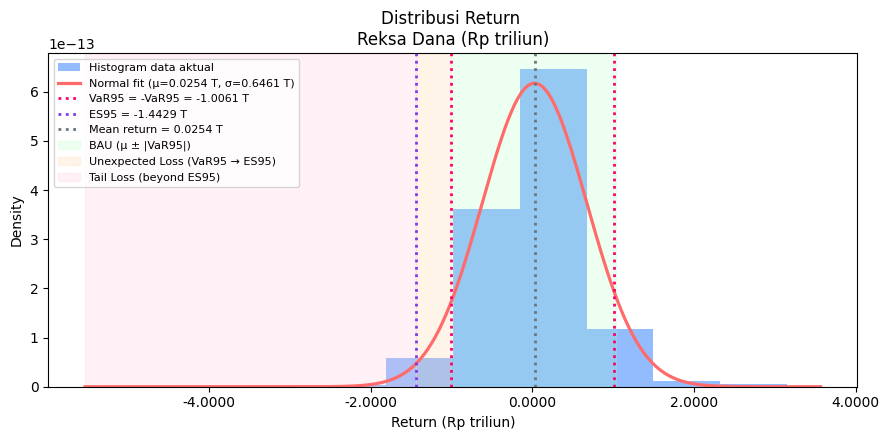

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_RD-full.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_RD"               # ganti dengan nama kolom PL
ASSET_NAME = "Reksa Dana"                  # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

# VaR95 di ruang PL (5% kiri; biasanya negatif)
q05 = series.quantile(1 - alpha)

# Expected Shortfall 95%
losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp TRILIUN
# =========================

def triliun_number(x: float) -> str:
    """Konversi rupiah ke 'Rp triliun' (dalam string, 4 desimal)."""
    return f"{x / 1e12:,.4f}"

axis_fmt = FuncFormatter(lambda val, pos: triliun_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"
fit_color    = "#ff6b6b"
bau_color    = "#a5ffbd"   # BAU zone
ul_color     = "#ffd6a5"   # UL zone
tail_color   = "#ffc8dd"   # Tail Loss zone
var_color    = "#ff006e"
es_color     = "#8338ec"
mean_color   = "#6c757d"

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
pad_left = x_min - 0.05 * x_range
pad_right = x_max + 0.05 * x_range

x = np.linspace(pad_left, pad_right, 400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={triliun_number(mu)} T, σ={triliun_number(sigma)} T)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = -VaR95 = {triliun_number(q05)} T")

# Garis -VaR95
ax.axvline(-q05,
           linestyle=":",
           linewidth=2,
           color=var_color,)

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {triliun_number(ES95_pl)} T")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean return = {triliun_number(mu)} T")

# === ZONA BAU: μ ± |VaR95| (business-as-usual) ===
var_width = abs(q05)
bau_left  = mu - var_width
bau_right = mu + var_width
ax.axvspan(bau_left, bau_right,
           alpha=0.20,
           color=bau_color,
           label="BAU (μ ± |VaR95|)")

# === ZONA UL: dari VaR95 ke ES95 ===
ul_left  = ES95_pl
ul_right = q05
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (VaR95 → ES95)")

# === ZONA TAIL LOSS: dari ES95 ke arah kerugian yang lebih dalam ===
# (diasumsikan tail kerugian di sisi kiri, ES95_pl < q05 < mu)
tail_left  = pad_left
tail_right = ES95_pl
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (beyond ES95)")

# Sumbu x dalam Rp triliun
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp triliun)")
ax.set_xlabel("Return (Rp triliun)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## Komparasi Fixed Income


=== Ringkasan Statistik Total Instrumen (Rp) ===
                       N    Mean_Level  StdDev_Level     Min_Level  \
Obligasi_Korporasi  22.0  1.079832e+13  4.921882e+11  9.594683e+12   
MTN                 22.0  3.221095e+12  9.058349e+11  1.588948e+12   
EBA                 22.0  4.910367e+11  3.731863e+10  4.496724e+11   

                       Max_Level      CAGR  
Obligasi_Korporasi  1.162281e+13 -0.103787  
MTN                 4.820019e+12 -0.469586  
EBA                 5.748842e+11 -0.121423  

=== Perubahan Persentase Bulanan (%) ===
            Obligasi_Korporasi        MTN       EBA
Date                                               
2025-06-30            1.979897   0.022829 -3.193201
2025-07-31           -7.430487 -31.543198  1.121787
2025-08-31            3.277072  -2.482531  2.109181
2025-09-30           -4.112565  -7.485377 -2.996524
2025-10-31           -3.546335  -9.671422  1.359235


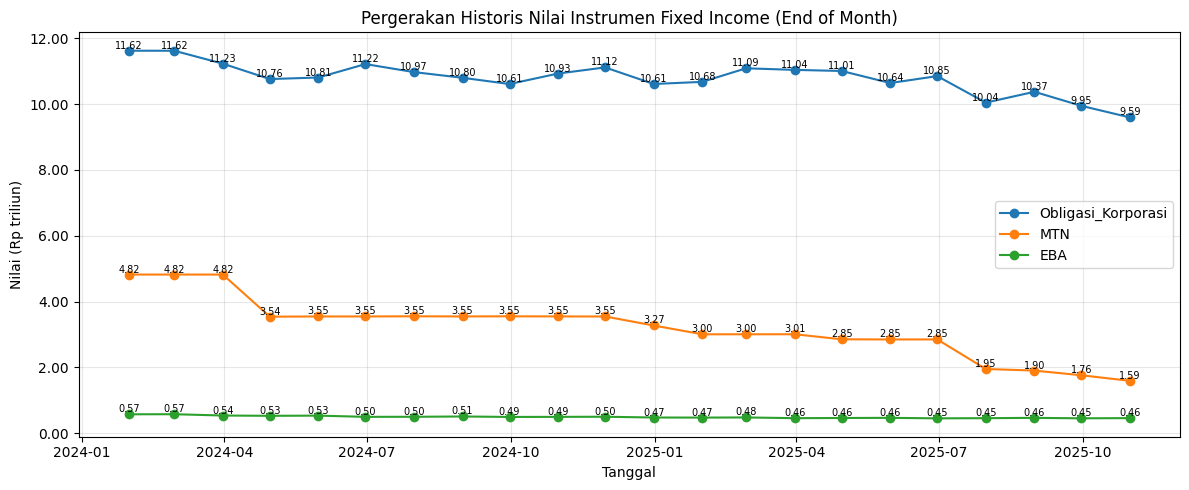

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# =========================
# 1. READ DATA
# =========================

file_path = "compare_fixed_income.xlsx"
df = pd.read_excel(file_path)

# Pastikan kolom Date ada
if "Date" not in df.columns:
    raise ValueError("Kolom 'Date' tidak ditemukan dalam file Excel.")

# Konversi secara manual ke datetime (format dd/mm/yy)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

# Buat index
df = df.set_index("Date").sort_index()

# Asset columns — persis dari data kamu
asset_cols = ["Obligasi_Korporasi", "MTN", "EBA"]

# Konversi ke numeric (cleaning)
df[asset_cols] = df[asset_cols].replace({",": ""}, regex=True)
df[asset_cols] = df[asset_cols].apply(pd.to_numeric, errors="coerce")

data = df[asset_cols].dropna(how="all")

# =========================
# 2. FORMAT Rp TRILIUN
# =========================

def triliun_fmt(x, pos=None):
    return f"{x / 1e12:,.2f}"

rp_tril_formatter = FuncFormatter(triliun_fmt)

# =========================
# 3. SUMMARY STATISTICS
# =========================

summary_stats = data.agg(["count", "mean", "std", "min", "max"]).T
summary_stats.columns = ["N", "Mean_Level", "StdDev_Level", "Min_Level", "Max_Level"]

# CAGR (jika data bulanan)
n_periods = len(data)
months = n_periods - 1
if months > 0:
    years = months / 12
    cagr = (data.iloc[-1] / data.iloc[0]) ** (1 / years) - 1
    summary_stats["CAGR"] = cagr
else:
    summary_stats["CAGR"] = np.nan

print("\n=== Ringkasan Statistik Total Instrumen (Rp) ===")
print(summary_stats)

# Monthly percentage change
pct_change = data.pct_change() * 100
print("\n=== Perubahan Persentase Bulanan (%) ===")
print(pct_change.tail())

# =========================
# 4. PLOT LEVEL HISTORIS + LABEL TITIK
# =========================

fig, ax = plt.subplots(figsize=(12, 5))

for col in asset_cols:
    ax.plot(data.index, data[col], marker="o", label=col)

    # Tambahkan label di setiap titik
    for x, y in zip(data.index, data[col]):
        ax.text(
            x, y,
            f"{y/1e12:,.2f}",         # tampilkan dalam triliun
            fontsize=7,
            ha="center",
            va="bottom",
            rotation=0,
            color="black"
        )

ax.set_title("Pergerakan Historis Nilai Instrumen Fixed Income (End of Month)")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Nilai (Rp triliun)")
ax.yaxis.set_major_formatter(rp_tril_formatter)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

## Obligasi Korporasi Full 2

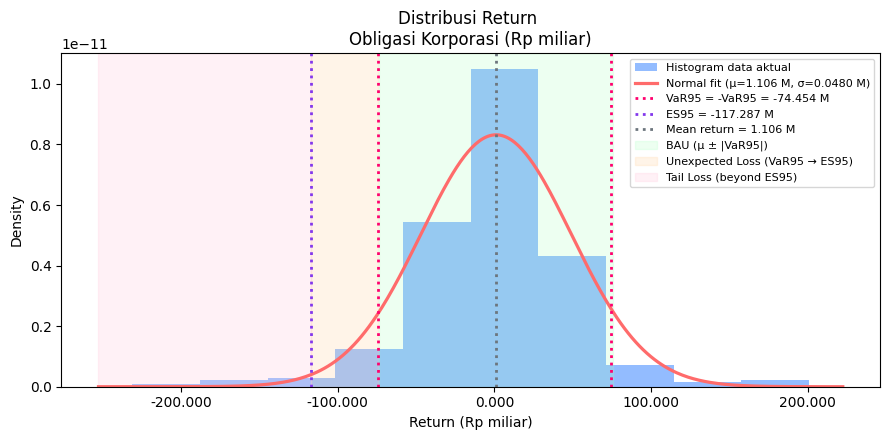

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_Obl.Korp_full2.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "Profit/Loss"               # ganti dengan nama kolom PL
ASSET_NAME = "Obligasi Korporasi"                  # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

# VaR95 di ruang PL (5% kiri; biasanya negatif)
q05 = series.quantile(1 - alpha)

# Expected Shortfall 95%
losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp TRILIUN
# =========================

def miliar_number(x: float) -> str:
    """Konversi rupiah ke 'Rp miliar' (dalam string, 3 desimal)."""
    return f"{x / 1e9:,.3f}"

axis_fmt = FuncFormatter(lambda val, pos: miliar_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"
fit_color    = "#ff6b6b"
bau_color    = "#a5ffbd"   # BAU zone
ul_color     = "#ffd6a5"   # UL zone
tail_color   = "#ffc8dd"   # Tail Loss zone
var_color    = "#ff006e"
es_color     = "#8338ec"
mean_color   = "#6c757d"

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
pad_left = x_min - 0.05 * x_range
pad_right = x_max + 0.05 * x_range

x = np.linspace(pad_left, pad_right, 400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={miliar_number(mu)} M, σ={triliun_number(sigma)} M)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = -VaR95 = {miliar_number(q05)} M")

# Garis -VaR95
ax.axvline(-q05,
           linestyle=":",
           linewidth=2,
           color=var_color,)

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {miliar_number(ES95_pl)} M")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean return = {miliar_number(mu)} M")

# === ZONA BAU: μ ± |VaR95| (business-as-usual) ===
var_width = abs(q05)
bau_left  = mu - var_width
bau_right = mu + var_width
ax.axvspan(bau_left, bau_right,
           alpha=0.20,
           color=bau_color,
           label="BAU (μ ± |VaR95|)")

# === ZONA UL: dari VaR95 ke ES95 ===
ul_left  = ES95_pl
ul_right = q05
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (VaR95 → ES95)")

# === ZONA TAIL LOSS: dari ES95 ke arah kerugian yang lebih dalam ===
# (diasumsikan tail kerugian di sisi kiri, ES95_pl < q05 < mu)
tail_left  = pad_left
tail_right = ES95_pl
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (beyond ES95)")

# Sumbu x dalam Rp miliar
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp miliar)")
ax.set_xlabel("Return (Rp miliar)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## Saham (For WG)

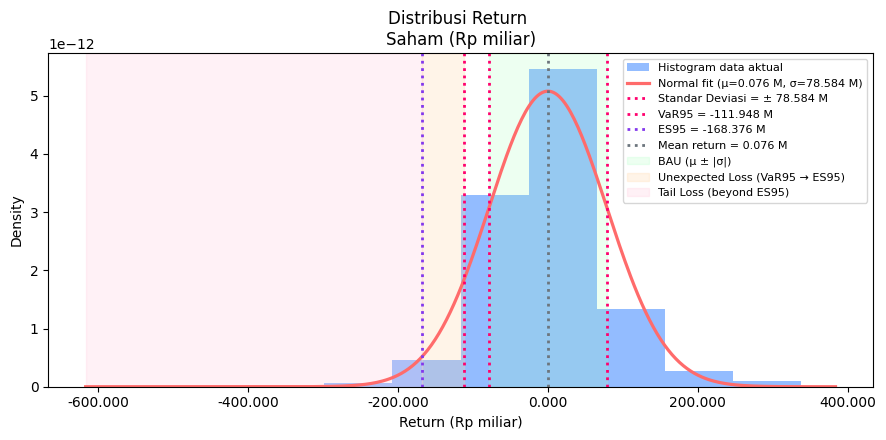

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_instruments.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_Saham"               # ganti dengan nama kolom PL
ASSET_NAME = "Saham"                  # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

# VaR95 di ruang PL (5% kiri; biasanya negatif)
q05 = series.quantile(1 - alpha)

# Expected Shortfall 95%
losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp MILIAR
# =========================

def miliar_number(x: float) -> str:
    """Konversi rupiah ke 'Rp miliar' (dalam string, 3 desimal)."""
    return f"{x / 1e9:,.3f}"

axis_fmt = FuncFormatter(lambda val, pos: miliar_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"
fit_color    = "#ff6b6b"
bau_color    = "#a5ffbd"   # BAU zone
ul_color     = "#ffd6a5"   # UL zone
tail_color   = "#ffc8dd"   # Tail Loss zone
var_color    = "#ff006e"
es_color     = "#8338ec"
mean_color   = "#6c757d"

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
pad_left = x_min - 0.05 * x_range
pad_right = x_max + 0.05 * x_range

x = np.linspace(pad_left, pad_right, 400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={miliar_number(mu)} M, σ={miliar_number(sigma)} M)")

# Garis Sigma
ax.axvline(sigma,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"Standar Deviasi = ± {miliar_number(sigma)} M")

# Garis -Sigma
ax.axvline(-sigma,
           linestyle=":",
           linewidth=2,
           color=var_color)

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = {miliar_number(q05)} M")

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {miliar_number(ES95_pl)} M")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean return = {miliar_number(mu)} M")

# === ZONA BAU: μ ± |σ| (business-as-usual) ===
sigma_width = abs(sigma)
bau_left  = mu - sigma_width
bau_right = mu + sigma_width
ax.axvspan(bau_left, bau_right,
           alpha=0.20,
           color=bau_color,
           label="BAU (μ ± |σ|)")

# === ZONA UL: dari VaR95 ke ES95 ===
ul_left  = ES95_pl
ul_right = q05
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (VaR95 → ES95)")

# === ZONA TAIL LOSS: dari ES95 ke arah kerugian yang lebih dalam ===
# (diasumsikan tail kerugian di sisi kiri, ES95_pl < q05 < mu)
tail_left  = pad_left
tail_right = ES95_pl
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (beyond ES95)")

# Sumbu x dalam Rp miliar
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp miliar)")
ax.set_xlabel("Return (Rp miliar)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

## Reksa Dana (For WG)